In [1]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import nolds as nolds
import os

Parámetros del sistema

In [1]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 8 # Frecuencia natural x<0
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 100 # Numero de fonones
X_0 = 10 # Condición inicial

In [3]:
dwc = 0.006 # paso en la frecuencia externa
wc =  np.array([i*dwc for i in range(int(0.5/dwc),int(2/dwc)+1)]) # Frecuencia fuerza externa

In [4]:
w =  wc[[i*8 for i in range(32)]] # Frecuencia fuerza externa
n = np.size(w)
print(w)

[0.498 0.546 0.594 0.642 0.69  0.738 0.786 0.834 0.882 0.93  0.978 1.026
 1.074 1.122 1.17  1.218 1.266 1.314 1.362 1.41  1.458 1.506 1.554 1.602
 1.65  1.698 1.746 1.794 1.842 1.89  1.938 1.986]


In [9]:
dt = 0.002 # Paso de tiempo
t0 = 0
tf = 150 # Tiempo de medida
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

Frecuencia natural del oscilador

In [6]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [7]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [8]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/np.pi)**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [9]:
x = np.linspace(-25,25,2500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


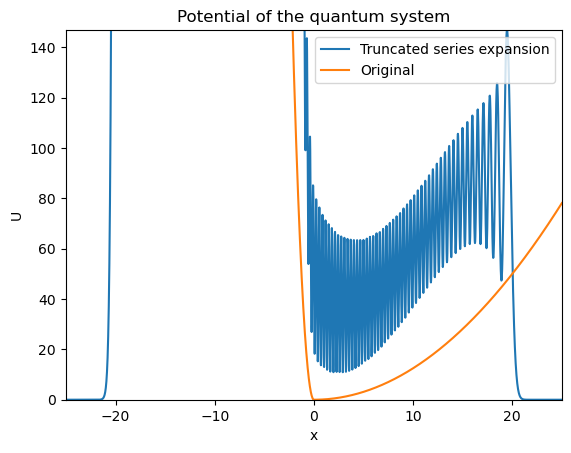

In [10]:
fig1 = plt.figure()
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

In [11]:
fig1.savefig('Quantum_potential (N = '+str(N)+' phonons).png')

Simulación de la dinámica cuántica

In [ ]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'f_0 = '+str(f_0),'N = '+str(N),'X_0 = '+str(X_0),'w = '+str(w)]
with open('param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [13]:
def check_state(psi):
    check = np.sum(np.diagonal(ket2dm(psi).full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [14]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5)*math.sqrt(w_0*m))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m)
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

In [15]:
def H1coeff(t,args):
    return -f_0*m*np.cos(args['w']*t)

In [16]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
options = Options(store_states=True,nsteps=1000000)
for i in tqdm(range(n)):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options,args=args))

 78%|███████▊  | 25/32 [10:15:52<2:26:13, 1253.29s/it]

Diagrama de bifurcación cuántico

In [ ]:
qbif = np.zeros([w.size,np.size(x)])

for k in range(w.size):

    T = 2*math.pi/w[k] # Periodo fuerza externa
    Np = int(tf/T) # Número de puntos que usamos en el promedio
    ind = np.array([np.searchsorted(tvec,T*(i+1)) for i in range(Np-1)]) # Calculamos los índices
    aux = 0

    dop = np.zeros([np.size(ind),np.size(x)])

    for j in tqdm(range(np.size(ind))):
        fdo = 0
        for i in range(N):
            fdo = fdo + result[k].states[ind[j]].full()[i]*autoest(i,x,True)
        dop[j] = np.abs(fdo)**2

    for i in range(np.size(ind)):
        aux = aux + dop[i]
    qbif[k] = aux/(Np-1)

100%|██████████| 46/46 [00:14<00:00,  3.21it/s]


In [ ]:
for i in range(w.size):
    np.savetxt('qbif ω = '+str(format(w[i],'.3f'))+'.txt',qbif[i])

Cargamos los datos

In [5]:
x = np.linspace(-25,25,2500)
qbif = np.zeros([w.size,x.size])
for i in range(w.size):
    a = open('qbif ω = '+str(format(w[i],'.3f'))+'.txt','r')
    Qbif = a.readlines()
    for j in range(len(Qbif)):
        Qbif[j] = float((Qbif[j].split())[0])
    qbif[i] = (Qbif)

In [6]:
xp = []
vp = []

for i in range(wc.size):
    b = open('xp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    c = open('vp ω = '+str(format(wc[i],'.3f'))+'.txt','r')
    XP = b.readlines()
    VP = c.readlines()
    for j in range(len(XP)):
        XP[j] = float((XP[j].split())[0])
        VP[j] = float((VP[j].split())[0])
    xp.append(XP)
    vp.append(VP)

b.close()
c.close()

In [7]:
e = open('explyap.txt','r')

explyap = e.readlines()
lyap = np.zeros(wc.size)
disp = np.zeros(wc.size)

for i in range(wc.size):
    explyap[i] = explyap[i].split()
    lyap[i] = explyap[i][0]
    disp[i] = explyap[i][1]

e.close()

Representación gráfica

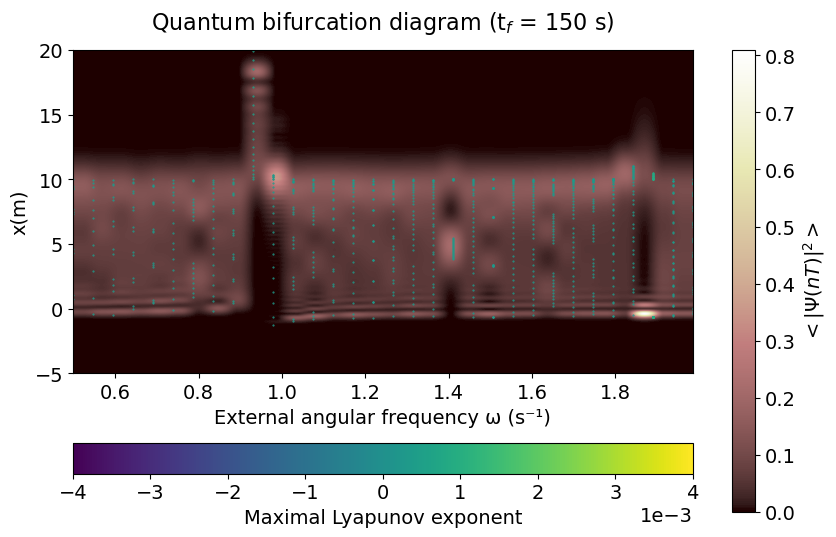

In [10]:
fig,ax = plt.subplots(figsize = (10,6))

nrm = mpl.colors.Normalize(0, qbif.max())

norm = colors.Normalize(vmin=-0.004, vmax=0.004)
f2rgb = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('viridis'))

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

im = ax.imshow(np.flip(np.transpose(qbif),axis = 0),cmap='pink',norm = nrm, aspect = 'auto', extent = [min(w),max(w),min(x),max(x)])
cbar = plt.colorbar(im, pad = 0.05)
cbar.set_label(label='$<|Ψ(nT)|^2>$',fontsize = 14)
rep_w = np.searchsorted(wc, w)
for i in rep_w:
        ax.plot(wc[i]*np.ones(np.size(xp[i][:int(np.size(3*xp[i])/20)])),np.array(xp[i][:int(3*np.size(xp[i])/20)],dtype=object),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=1)
ax.set_title('Quantum bifurcation diagram (t$_f$ = '+str(tf)+' s)',fontsize = 16, pad = 15)
ax.set_ylabel('x(m)',fontsize = 14)
ax.set_xlabel('External angular frequency ω (s⁻¹)',fontsize = 14)
#plt.ylim([min(x),max(x)])
plt.ylim([-5,20])

cbar2 = plt.colorbar(f2rgb,orientation="horizontal", pad = 0.15)
cbar2.set_label(label='Maximal Lyapunov exponent',fontsize = 14)
cbar2.formatter.set_powerlimits((0, 0))
'''
axins = ax.inset_axes([0.55, 0.15, 0.4, 0.25])
for i in (rep_w-1):
    axins.plot(wc[i]*np.ones(np.size(xp[i])),np.array(xp[i],dtype=object),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=1)
x1, x2, y1, y2 = 0.0, 0.125, -0.1, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(colors='white')
#ax.indicate_inset_zoom(axins, edgecolor="black")
'''

plt.savefig('Qbif ('+str(tf)+' s).png')
plt.show()